In [43]:
#https://nilearn.github.io/dev/glm/second_level_model.html

import os
import glob
import nilearn 
import itertools
import numpy as np 
import pandas as pd
import nibabel as nib

from scipy.stats import norm
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.second_level import SecondLevelModel
from nilearn.datasets import fetch_localizer_contrasts
from nilearn.image import get_data, math_img
from nilearn import plotting, image, datasets
from nilearn.glm.second_level import non_parametric_inference
from nilearn.glm import threshold_stats_img
from numpy import savetxt


# Init variables
init_folder='/home/traaffneu/margal/code/multirat_se/script/'
analysis_folder='/project/4180000.19/multirat_stim/rabies/preprocess'
z_scores_path = "/project/4180000.19/multirat_stim/rabies_test/first_level_analysis/z_score/"
beta_path = "/project/4180000.19/multirat_stim/rabies_test/first_level_analysis/beta_estimates/"


# Data path
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
metadata_path = '/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'

# Paths for the directories
output_dir = '/project/4180000.19/multirat_stim/rabies_test/second_level_analysis/'
image_dir = os.path.join(output_dir, 'image/')
residuals_dir = os.path.join(output_dir, 'residuals/')
z_score_dir = os.path.join(output_dir, 'z_score/')
beta_dir = os.path.join(output_dir, 'beta_estimates/')
p_value_dir = os.path.join(output_dir, 'p_value/')
clusters_dir = os.path.join(output_dir, 'clusters/')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(image_dir):
    os.makedirs(image_dir)
if not os.path.exists(residuals_dir):
    os.makedirs(residuals_dir)

if not os.path.exists(z_score_dir):
    os.makedirs(z_score_dir)
if not os.path.exists(beta_dir):
    os.makedirs(beta_dir)
if not os.path.exists(p_value_dir):
    os.makedirs(p_value_dir)
if not os.path.exists(clusters_dir):
    os.makedirs(clusters_dir)
    
df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]


In [44]:
ID = "0"+str(200+3)+"00"
dataset = glob.glob(beta_path+'beta_sub-{}??_ses-1.nii.gz'.format(ID))

print(ID)
print(dataset)

020300
[]


ID: 02001
number of subjects: 10


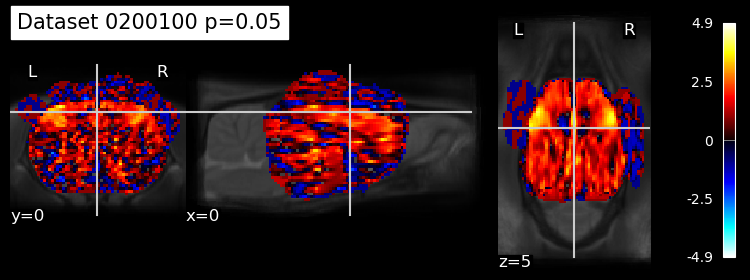

cluster treshold:  2.4684059619903564
Cluster table: ok
(nb clusters, dimension): (5, 3)


KeyboardInterrupt: 

In [121]:
#https://nilearn.github.io/dev/auto_examples/07_advanced/plot_bids_analysis.html 

for index in range(1, 19):
    
    ID = "0"+str(2000+index)
    print("ID:", ID)
 
    dataset = glob.glob(beta_path+'beta_sub-{}??_ses-1.nii.gz'.format(ID))
    
    n_subject = len(dataset)                                                           
    print("number of subjects:", n_subject)

    second_level_input = dataset
    design_matrix = pd.DataFrame([1] * len(second_level_input), 
                                columns=["intercept"])


    # --- Specify the model and fit it --- 
    second_level_model = SecondLevelModel(smoothing_fwhm=0.1,
                                          minimize_memory=False)        #if want to get residuals?

    second_level_model = second_level_model.fit(second_level_input,
                                                design_matrix=design_matrix)


    # --- Estimate the contrast --- 
    second_stat_map = second_level_model.compute_contrast(second_level_contrast='intercept', output_type='all') 

    nib.save(second_stat_map['z_score'], z_score_dir+'z_score_dataset-{}.nii.gz'.format(ID))          #save z_score map
    nib.save(second_stat_map['effect_size'], beta_dir+'beta_dataset-{}.nii.gz'.format(ID))            #save the beta estimates
    nib.save(second_stat_map['p_value'], p_value_dir+'p_value_dataset-{}.nii.gz'.format(ID))          #save the p_value

    # # --- Bonferronie correction --- 
    # threshold_uncorrected = 0.001
    # threshold_corrected = threshold_uncorrected / n_subject   #use as input for argument "threshold" when plotting

    p_val = 0.05
    p_unc = norm.isf(p_val)
    plot_stat = plotting.plot_stat_map(second_stat_map['z_score'],
                                        bg_img = template_path,
                                        threshold = p_val,              #threshold p=0.05 uncorrected -> reduces false negative levels
                                        cut_coords= (0 ,0, 5.5),        
                                        display_mode='ortho',
                                        draw_cross=True,
                                        colorbar=True,
                                        title="Dataset {}00 p={}".format(ID, p_val))

    plt.savefig(image_dir+'stat_map_dataset-{}_z_score.png'.format(ID)) 
    plotting.show()

    
    #-- Extract clusters -- https://nilearn.github.io/dev/auto_examples/04_glm_first_level/plot_predictions_residuals.html#sphx-glr-auto-examples-04-glm-first-level-plot-predictions-residuals-py

    from nilearn.reporting import get_clusters_table
    from nilearn.maskers import NiftiSpheresMasker

    colorbar = plot_stat._cbar                      # get the statistical scale from the plot
    vmin, vmax = colorbar.mappable.get_clim()
    set_tresh = vmax / 2                            # get the stat_threshold for cluster, depending on the dataset
    print("cluster treshold: ", set_tresh)
    
    table = get_clusters_table(second_stat_map['z_score'],
                            stat_threshold=set_tresh,
                            cluster_threshold=40)


    table.set_index("Cluster ID", drop=True)
    print('Cluster table: ok')

    coords = table.loc[range(0, len(table)), ['X', 'Y', 'Z']].values                     # get the clusters' x, y, and z coordinates (if want the 4 largest, range(0, 4)
    coords = coords.reshape(-1, 3)                                                       # reshape in 3D
    print("(nb clusters, dimension):", coords.shape)                                     # output = (number_clusters, 3)
    
    masker = NiftiSpheresMasker(coords, radius=1)                                        # extracts time series data from a set of spherical regions of interest (ROIs) in a 3D fMRI image
    
    fmri_img = image.concat_imgs(dataset)

    real_timeseries = masker.fit_transform(fmri_img)                                      # applies the masker to an fMRI image, outputs 2D numpy array
    
    savetxt(clusters_dir+'cluster_dataset-0{}.csv'.format(ID), real_timeseries, delimiter=',')       #save as .csv file



In [112]:
    #-- Extract clusters -- https://nilearn.github.io/dev/auto_examples/04_glm_first_level/plot_predictions_residuals.html#sphx-glr-auto-examples-04-glm-first-level-plot-predictions-residuals-py

    from nilearn.reporting import get_clusters_table
    from nilearn.maskers import NiftiSpheresMasker

    colorbar = plot_stat._cbar                      # get the statistical scale from the plot
    vmin, vmax = colorbar.mappable.get_clim()
    set_tresh = vmax / 2                            # get the stat_threshold for cluster, depending on the dataset
    print("cluster treshold: ", set_tresh)
    
    table = get_clusters_table(second_stat_map['z_score'],
                            stat_threshold=set_tresh,
                            cluster_threshold=40)


    table.set_index("Cluster ID", drop=True)
    print('Cluster table: ok')

    coords = table.loc[range(0, len(table)), ['X', 'Y', 'Z']].values                     # get the clusters' x, y, and z coordinates (if want the 4 largest, range(0, 4)
    coords = coords.reshape(-1, 3)                                                       # reshape in 3D
    print("(nb clusters, dimension):", coords.shape)                                                                  # output = (number_clusters, 3)
    
    masker = NiftiSpheresMasker(coords, radius=1)                                        # extracts time series data from a set of spherical regions of interest (ROIs) in a 3D fMRI image
    
    fmri_img = image.concat_imgs(dataset)

    real_timeseries = masker.fit_transform(fmri_img)                                      # applies the masker to an fMRI image, outputs 2D numpy array
    
    savetxt(clusters_dir+'cluster_dataset-0{}.csv'.format(ID), real_timeseries, delimiter=',')       #save as .csv file


cluster treshold:  2.410496950149536
Cluster table: ok
(nb clusters, dimension): (1, 3)


In [114]:
print(coords.shape)
print(table)

(6, 3)
   Cluster ID         X         Y         Z  Peak Stat  Cluster Size (mm3)
0           1  2.860001 -4.309999  2.835001   4.554172                   4
1           2 -5.239999 -5.509999  5.235001   4.454637                   7
2           3  2.560001 -6.109999  6.735001   4.403016                  19
3           4  1.060001 -6.109999  3.735001   4.332162                  17
4           5 -4.339999 -4.909999  1.935000   3.986346                   3
5           6 -2.539999 -6.709999  5.535001   3.461884                   1
